In [6]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KDTree

import numpy as np
import matplotlib.pylab as plt

# load data
from sklearn.datasets import make_moons

all_features, all_targets = make_moons(n_samples=10000, noise=0.05)

In [7]:
def agglo_hierarchial_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    clustering.fit(data)
    labels = clustering.labels_
    return labels

def hierarchial_clustering(data, n_clusters):
    return agglo_hierarchial_clustering(data, n_clusters)

def sample_points(a, size, return_indices=False):
    n = a.shape[0]
    idx = np.random.choice(np.arange(n), size=size, replace=False)
    x = a[idx, :]

    if return_indices:
        return idx, x
    return x

def representation_points(x, m, alpha):
    _, r = sample_points(x, size=m, return_indices=True)
    centroid = x.mean(axis=0)
    rr = r + alpha*(centroid - r)
    # x[idx, :] = rr
    return rr

def scatter(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], **kwargs)

def axscatter(ax, x, **kwargs):
    ax.scatter(x[:,0], x[:,1], **kwargs)

def split(features, target, n_clusters):
    return [features[target == i, :] for i in range(n_clusters)]

def plot_representation_points(x, label, n_clusters, R):
    x_groups = split(x, label, n_clusters)

    for i, d in enumerate(x_groups):    
        scatter(d)
        scatter(R[i])

    plt.title('Representation Points')
    plt.show()

def representation_matrix(X, n_clusters, m, sample_n, alpha=0.1, target=None, plot=False):
    '''
    returns: (n_clusters, m, d) matrix
    where m is number of representation points for each cluster
    and d is dimension of our points
    '''

    # cluster stochastic sampled data
    idx, x = sample_points(X, size=int(sample_n*X.shape[0]), return_indices=True)
    if target is None:
        print("Warning: CURE's hierarchial clustering is not implemented yet, switching back to sklearn's methods")
        label = hierarchial_clustering(x, n_clusters=n_clusters)
    else:
        label = target[idx]

    R = np.zeros((n_clusters, m, X.shape[1]))

    # group by label
    x_groups = split(x, label, n_clusters)

    for i, d in enumerate(x_groups):
        r = representation_points(d, m, alpha)
        R[i, :, :] = r

    if plot:
        plot_representation_points(x, label, n_clusters, R)

    return R

def plot_distance_fields(X, R, D):
    n_clusters, m = R.shape[0:2]
    fig, axs = plt.subplots(m+1, n_clusters, figsize=(12, 20))

    for j in range(n_clusters):
        for i, x in enumerate(split(X, all_targets, n_clusters)):
            axs[0,j].scatter(x[:,0], x[:,1])
        
    for i in range(n_clusters):
        axs[0,i].scatter(R[i, :, 0], R[i, :, 1])

    for cluster in range(n_clusters):
        for i in range(0, m):
            colors = D[cluster, i, :]
            axs[i+1,cluster].scatter(X[:,0], X[:,1], c=colors)
            r = R[cluster, i]
            axs[i+1,cluster].scatter(r[0], r[1], color='red' if cluster == 0 else 'blue')

    plt.suptitle('Distance Fields')
    plt.tight_layout()
    plt.show()

def distance_fields(X, R, plot=False):
    n_clusters, m = R.shape[0:2]
    D = np.zeros((n_clusters, m, X.shape[0]))

    for c in range(n_clusters):
        for i in range(m):
            d = X - R[c,i]
            D[c,i,:] = (d ** 2).sum(axis=1)

    if plot:
        plot_distance_fields(X, R, D)

    return D

def cluster_fit(X, D, m):
    Z = D.reshape((-1, X.shape[0]))
    clusters = Z.argmin(axis=0) // m
    return clusters

def CURE(X, n_clusters=2, m=10, sample_n=0.05, alpha=0.1, return_locals=True, target=None):
    if n_clusters > 2:
        raise Exception("Not implemented: need CURE cluster merge function")
    R = representation_matrix(X, n_clusters, m, sample_n, alpha, target=target, plot=False)
    D = distance_fields(X, R, plot=False)
    c = cluster_fit(X, D, m)
    
    return c if not return_locals else c, R, D

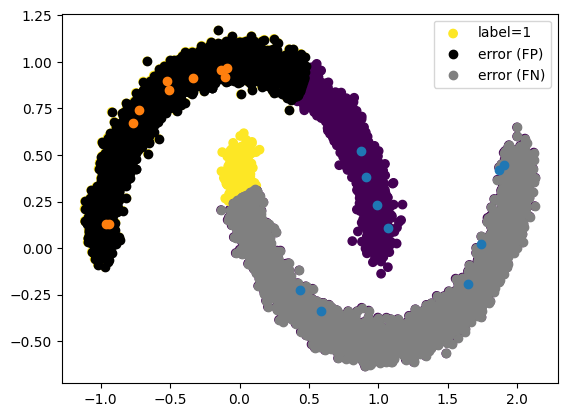

In [8]:
X, y = all_features, all_targets

# number of representation points for each cluster
m = 10
n_clusters = 2

c, R, _ = CURE(X, m=m, n_clusters=n_clusters, sample_n=0.5, alpha=0.1)
scatter(X, c=c, label='label=1')

scatter(X[y < c], color='black', label='error (FP)')
scatter(X[y > c], color='gray', label='error (FN)')

for id in range(n_clusters):
    scatter(R[id])

plt.legend()
plt.show()

##### (Hidden) Further experimentation

In [9]:
def _testing_cure_for_iterations():
    # Note: 
    
    X, y = all_features, all_targets
    target = None
    iterations = 10

    fig, axs = plt.subplots(iterations,1, figsize=(5,iterations*2))

    for i in range(iterations):
        c, l = CURE(X, target=c, return_locals=True)
        axscatter(axs[i], X, c=c, label='label=1')

        dif = c != y
        axscatter(axs[i], X[dif], color='pink', label='errors')

        for j in range(n_clusters):
            label = f'c{j} r.p'
            axscatter(axs[i], l['R'][j], label=label)

        # axs[i].title('Result Clusters')

    plt.legend(loc='upper right')
    fig.tight_layout()
    plt.show()

# Clustering

In [155]:
def find_kth_best(x, k=2):
    k -= 1
    a = np.argpartition(a=x, kth=k)
    return a[1]

class Cluster:
    def __init__(self, point, point_index, crep=10):
        '''
        rep: cluster representative points
        '''

        self.closest = None
        self.closest_dist = np.inf
        self.rep = np.array([point])
        self.rep_idx = np.array([point_index])
        self.id = point_index

        self.xids = self.rep_idx
        self.x = self.rep
        self.crep = crep

    def merge(self, other):
        self.rep = np.vstack((self.rep, other.rep))
        self.x = np.vstack((self.x, other.x))
        self.xids = np.vstack((self.xids, other.xids))
        
        if other.closest != self.id and other.closest_dist < self.closest_dist:
            self.set_closest(other.closest, other.closest_dist)
        else:
            self.set_closest(None, np.inf)

        if self.rep.shape[0] > self.crep:
            self.rep_idx, self.rep = sample_points(self.rep, self.crep, return_indices=True)

    def dist2(self, other):
        R = self.rep
        R2 = other.rep
        m = min(R.shape[0], R2.shape[0])
        if R.shape[0] > m:
            R, R2 = R2, R

        md = np.inf
        for i in range(m):
            d = ((R2 - R[i]) ** 2).sum(axis=1).min(axis=-1)
            md = min(d, md)

        return md
    
    def set_closest(self, other, d):
        self.closest = other
        self.closest_dist = d

    # def update_distances(self, clist):
    #     c, d = self.find_closest_cluster(clist)
    #     self.set_closest(c, d)
        
    def __str__(self):
        return str(self.rep_idx.tolist())
    
    def find_closest_cluster(self, cluster_list):
        d = np.array([self.dist2(c) for c in cluster_list])
        i = find_kth_best(d, 2)
        print('count of i:', d[d==d[i]].shape)
        print(d[i-2:i+3])
        
        return cluster_list[i].id, d[i]

In [156]:
def find_closest_cluster(cluster, C):
    id, d = cluster.find_closest_cluster(list(C.values()))
    return id, d

def init_clusters():
    C = {i: Cluster(X[i], i) for i in range(X.shape[0])}

    tree = KDTree(X, 10, metric='euclidean')

    qres = tree.query(X, k=2)
    distances, nearest = qres[0][:,1], qres[1][:,1]

    for i in range(X.shape[0]):
        C[i].set_closest(nearest[i], distances[i])

    return C, distances.argmin()

def get_cluster_ids(C):
    # ids = [c.id for c in C.values()]
    # return np.array(ids)
    return list(C.keys())

# X = sample_points(X, 500)

0.0011283139610244884
Current:  233
merging with  268
count of i: (1,)
[3.43269591e+00 1.65601161e+00 1.70621504e-03 1.15198424e+00
 1.05572635e+00]
B
0.0017062150392700203


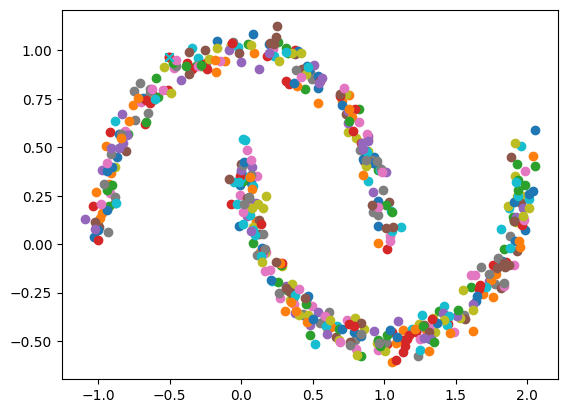

merging with  383
count of i: (1,)
[4.47872718e-01 6.32775468e+00 4.50933819e-04 4.15515725e+00
 5.87016591e+00]
B
merging with  483
count of i: (1,)
[2.44942285e-02 4.29523431e+00 4.50933819e-04 3.22773972e+00
 3.75128327e+00]
B
merging with  483


KeyError: 483

In [169]:
C, id = init_clusters()

def merge(i, j):
    print('merging with ', j)
    C[i].merge(C[j])
    C.pop(j)
    
    id, dist = find_closest_cluster(C[i], C)
    if (not (id in C.keys())) or id == i:
        C[i].set_closest(None, np.inf)
        print("A")
        return True
    elif id == j:
        print("HUSTON!")
        return True
    else:
        print("B")
        C[i].set_closest(id, dist)

    # if not (C[i].closest in C.keys()):
    #     print("A")
    #     C[i].set_closest(None, np.inf)
        
    # if not C[i].closest:
    #     print("B")
    #     id, dist = find_closest_cluster(C[i], C)
        
    #     if id != i:
    #         print("NEAR: ", id)
    #         C[i].set_closest(id, dist)
    #     else:
    #         return True
    #         raise Exception("DAMN")
    #         print("O_O")
       
current = id
nearest = C[id].closest

print(C[id].closest_dist)

cc = []
c = C[current]

print('Current: ', current)

for id in range(201):
    res = merge(current, nearest)
    if res:
        break
    nearest = c.closest
    
    if id % 50 == 0:
        print(c.closest_dist)

        values = list(C.values())
        cc.append(values)

        for c in values:
            scatter(c.x)
        
        scatter(C[current].rep, marker='x')
        plt.show()

# _, axs = plt.subplots(5, 1)

# for clist in cc:
#     for c in clist:
#         scatter(c.x)
#     scatter(C[current].rep, marker='x')
#     plt.show()

In [ ]:
383, 457, 483,

In [166]:
C[current].closest

457

In [161]:
id, dist = find_closest_cluster(C[457], C)
id

count of i: (1,)
[4.49853347e+00 8.02667020e-01 4.50933819e-04 8.93006465e-01
 2.07166838e+00]


233

In [160]:
483 in C.keys()

False

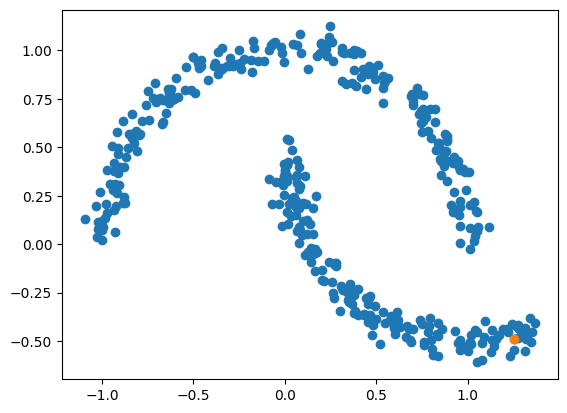

In [ ]:
scatter(C[233].x)
scatter(C[233].rep[0:1])


In [ ]:
C[233].find_closest_cluster(list(C.values()))

count of i: (1,)
[0.42389448 0.75230188 0.00230701 0.04620096 0.78076772]


(450, 0.0023070149336860525)

In [135]:
s = C[233]
clist = list(C.values())
dist = np.array([s.dist2(c) for c in clist])
id = find_kth_best(dist, 2)
dist[id]

0.0023070149336860525

In [122]:
[find_kth_best(dist,i) for i in range(1,4)]

[181, 181, 127]

In [113]:
id

181

In [104]:
dist = np.array([2.90443941, 0.46890804, 0.,         0.58251407, 1.36826737])

In [105]:
find_kth_best(dist, 2)

1

In [123]:
a = np.argpartition(dist, 1)
id = a[1]

array([[181]])

In [128]:
dist[0]

3.7259576095358094e-05

In [124]:
np.partition(dist, 1)

array([0.00000000e+00, 3.72595761e-05, 2.69953415e+00, 3.63493415e+00,
       3.44959238e-01, 1.52386299e+00, 1.46606790e+00, 1.20063479e+00,
       1.70053989e+00, 2.82159366e+00, 3.30696966e+00, 9.62408918e-01,
       1.21529061e+00, 1.09072833e+00, 3.77664940e+00, 3.52535543e+00,
       3.32156983e+00, 3.50977851e-01, 3.65362981e+00, 4.24245276e-01,
       2.95875623e+00, 3.60134817e+00, 3.01651603e+00, 1.62713737e+00,
       2.41100047e+00, 4.24956728e-01, 3.32119198e+00, 2.27990857e+00,
       3.63478245e+00, 2.00762227e+00, 1.60708738e+00, 3.93922425e+00,
       8.95647816e-01, 3.55386255e+00, 9.03987668e-01, 2.04643987e+00,
       3.70487739e-01, 2.79374465e-01, 9.32117716e-03, 1.88547552e+00,
       3.24687477e+00, 1.69020878e+00, 6.71046867e-01, 3.16531425e-01,
       3.58402752e+00, 3.67218571e+00, 3.32508449e+00, 3.94088343e-01,
       1.29088102e+00, 1.36402616e+00, 1.05565346e+00, 1.56389171e+00,
       3.47547525e-01, 2.27565491e-02, 2.58835103e-01, 6.82731331e-01,
      

In [72]:
233 in C.keys()

False

In [73]:
C[current].closest

KeyError: 233

In [ ]:
C[id].closest_dist

0.014992783806865136

In [ ]:
def find_closest_cluster(cluster, C):
    i, d = cluster.find_closest_cluster(C.values())
    return i, d

C = {i: Cluster(X[i], i) for i in range(X.shape[0])}

tree = KDTree(X, 10, metric='euclidean')

qres = tree.query(X, k=2)
distances, nearest = qres[0][:,1], qres[1][:,1]

for id in range(X.shape[0]):
    C[id].set_closest(nearest[id], distances[id])

AttributeError: 'Cluster' object has no attribute 'x'

In [ ]:
C[id]

3608

In [ ]:
KDTree.valid_metrics

['euclidean',
 'l2',
 'minkowski',
 'p',
 'manhattan',
 'cityblock',
 'l1',
 'chebyshev',
 'infinity']

In [91]:
n = X.shape[0]

for id in range(n):
    for j in range(id+1,n):
        if (X[id] == X[j]).all():
            print(id,j)

In [93]:
C[233]